<font size="3"><b> <p style="text-align: center;"> PUC MG - Pontifícia Universidade Católica de Minas Gerais</p> </b></font>

<font size="5"><b> <p style="text-align: center;"> Pós Graduação em Ciência de Dados e Big Data</p> </b></font>

<font size="4"><b> <p style="text-align: center;"> Trabalho de conclusão de curso</p> </b></font>

<font size="4"><b> Título:</b> Modelo de Predição de Sucesso de Startups</font>     
<font size="4"><b> Aluna:</b> Heloisa Senarese Mininel</font>

**Notebook 2:** Modelos de machine learning

Para o desenvolvimento deste trabalho foram utilizados os datasets disponíveis em:     
https://www.kaggle.com/justinas/startup-investments     
https://www.kaggle.com/kaustubh93/list-of-700-unicorn-companies-across-the-globe


**1. Importando as bibliotecas**

In [44]:
import pandas as pd 
import csv 
import numpy as np 
from datetime import datetime
import seaborn as sns 
from datetime import datetime, timedelta
import time
import seaborn as sns
import matplotlib.pyplot as plt

# For filling missing values
from sklearn.impute import KNNImputer

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn import svm

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# For unbalanced data
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE



In [2]:
import warnings
warnings.filterwarnings('ignore')

**2. Carregando os dados**

In [3]:
objects = pd.read_csv('objects.csv', low_memory=False)
funding_rounds = pd.read_csv('funding_rounds.csv')
unicornies = pd.read_csv('unicornies.csv', low_memory=False)


**3. Organizando o dataframe principal e checando os dados**

In [4]:
#Criando o dataframe

df_objects = (objects
              .merge(unicornies, how='left', left_on='name', right_on='Company name')
              .merge(funding_rounds, left_on='id', right_on='object_id')
             )

df = df_objects[['object_id', 'name', 'category_code', 'status', 'founded_at', 
                      'closed_at', 'state_code', 'relationships', 'participants',
                      'first_funding_at', 'last_funding_at', 'funding_rounds', 'funding_total_usd', 
                      'funded_at', 'funding_round_type','funding_round_code', 'raised_amount_usd',
                    'first_milestone_at', 'last_milestone_at', 'milestones', 
                      'Valuation (in $B)']]


In [5]:
#Transformando colunas de data de string para date type

df["founded_at"] = pd.to_datetime(df["founded_at"])
df['closed_at'] = pd.to_datetime(df['closed_at'])
df["funded_at"] = pd.to_datetime(df["funded_at"])
df["first_funding_at"] = pd.to_datetime(df["first_funding_at"])
df["last_funding_at"] = pd.to_datetime(df["last_funding_at"])
df["first_milestone_at"] = pd.to_datetime(df["first_milestone_at"])
df["last_milestone_at"] = pd.to_datetime(df["last_milestone_at"])


Transformando os dados em colunas boleanas (númerico = 1 ou 0)

In [6]:
#State:

top_5_states = ['CA', 'NY', 'MA', 'TX', 'FL']

df.loc[df.state_code.isin(top_5_states) == True, 'is_top5_states'] = 1

df.loc[df.state_code.isin(top_5_states) == False, 'is_not_top5_states'] = 1


In [7]:
#Categories:

top_5_categories = ['software', 'web', 'ecommerce', 'games_video', 'mobile']

df.loc[df.category_code.isin(top_5_categories), 'is_top5_cat'] = 1

df.loc[~df.category_code.isin(top_5_categories), 'is_not_top5_cat'] = 1

In [8]:
#Participants:

df.loc[df['participants'] > 1, 'more_than_1_participant'] = 1

In [9]:
#Relationships:

df.loc[df['relationships'] > 0, 'has_relationships'] = 1

In [10]:
#Round types:

df.loc[df['funding_round_type']=='venture', 'has_vc'] = 1

df.loc[df['funding_round_type']=='angel', 'has_angel'] = 1

df.loc[df['funding_round_type']=='series-a', 'has_seriesA'] = 1

df.loc[df['funding_round_type']=='series-b', 'has_seriesB'] = 1

df.loc[df['funding_round_type']=='series-c+', 'has_seriesC+'] = 1

df.loc[~df['Valuation (in $B)'].isnull(), 'is_unicorn'] = 1

In [11]:
#raised_amount:

df.loc[(df['status'] == 'acquired') | (df['status'] == 'ipo') | (df['is_unicorn']==1) |
       ((df['status'] == 'operating') & (df['funding_round_type'].isin(['series-a', 'series-b', 'series-c+']))
        & (df['funding_total_usd'] > 6000000)
       )
        
        , 'success'] = 1

df['success'] = df['success'].apply((lambda x: 1 if x == 1 else 0))

Checando nulos

In [12]:
# % de nulos
print(df.isnull().sum()* 100 / len(df))

object_id                   0.000000
name                        0.000000
category_code               2.779995
status                      0.000000
founded_at                 17.918899
closed_at                  94.407707
state_code                 31.820773
relationships               0.000000
participants                0.000000
first_funding_at            0.389541
last_funding_at             0.389541
funding_rounds              0.000000
funding_total_usd           0.000000
funded_at                   0.463649
funding_round_type          0.000000
funding_round_code          0.000000
raised_amount_usd           0.000000
first_milestone_at         37.553681
last_milestone_at          37.553681
milestones                  0.000000
Valuation (in $B)          99.467944
is_top5_states             55.022232
is_not_top5_states         44.977768
is_top5_cat                61.640634
is_not_top5_cat            38.359366
more_than_1_participant    66.180215
has_relationships          15.165508
h

Founded_at será inputado pela mediana de tempo até o first_round

In [13]:
non_missing_data = df[~df['founded_at'].isnull()]

#Median time between being founded and first funding

non_missing_data["time_1st_funding"] = ((non_missing_data["first_funding_at"]-non_missing_data["founded_at"])
                                        / np.timedelta64(1, 'D'))

median_time = non_missing_data['time_1st_funding'].median()


df['founded_at'] = df['founded_at'].fillna(df['first_funding_at'] - timedelta(days=median_time))

df['founded_at']=pd.to_datetime(df['founded_at'])

Checando nulos novamente

In [14]:
# % de nulos
print(df.isnull().sum() * 100 / len(df))

object_id                   0.000000
name                        0.000000
category_code               2.779995
status                      0.000000
founded_at                  0.068407
closed_at                  94.407707
state_code                 31.820773
relationships               0.000000
participants                0.000000
first_funding_at            0.389541
last_funding_at             0.389541
funding_rounds              0.000000
funding_total_usd           0.000000
funded_at                   0.463649
funding_round_type          0.000000
funding_round_code          0.000000
raised_amount_usd           0.000000
first_milestone_at         37.553681
last_milestone_at          37.553681
milestones                  0.000000
Valuation (in $B)          99.467944
is_top5_states             55.022232
is_not_top5_states         44.977768
is_top5_cat                61.640634
is_not_top5_cat            38.359366
more_than_1_participant    66.180215
has_relationships          15.165508
h

O que continou nulo, será excluído

In [15]:
#Pequeno % de nulos que, portanto, serão excluídos

df = df[~(df['founded_at'].isnull())]


In [16]:
# % de nulos
print(df.isnull().sum() * 100 / len(df) )

object_id                   0.000000
name                        0.000000
category_code               2.772390
status                      0.000000
founded_at                  0.000000
closed_at                  94.420993
state_code                 31.800723
relationships               0.000000
participants                0.000000
first_funding_at            0.321354
last_funding_at             0.321354
funding_rounds              0.000000
funding_total_usd           0.000000
funded_at                   0.395512
funding_round_type          0.000000
funding_round_code          0.000000
raised_amount_usd           0.000000
first_milestone_at         37.535653
last_milestone_at          37.535653
milestones                  0.000000
Valuation (in $B)          99.467579
is_top5_states             55.008557
is_not_top5_states         44.991443
is_top5_cat                61.660011
is_not_top5_cat            38.339989
more_than_1_participant    66.166572
has_relationships          15.153071
h

Tratando nulos no campo closed_at:     
Se a startup continua aberta, considerada a data em que o dataset foi obtido

In [17]:
df['closed_at'] = df['closed_at'].fillna('2013-12-31')
df['closed_at']=pd.to_datetime(df['closed_at'])

Criação de campos com a idade das datas

In [18]:
df["age"] = df["closed_at"]-df["founded_at"]
df["age"]=round(df.age/np.timedelta64(1,'M'))

df["first_funding_age"] = df["first_funding_at"]-df["founded_at"]
df["first_funding_age"]=round(df.first_funding_age/np.timedelta64(1,'M'))

df["last_funding_age"] = df["last_funding_at"]-df["founded_at"]
df["last_funding_age"]=round(df.last_funding_age/np.timedelta64(1,'M'))

df["first_milestone_age"] = df["first_milestone_at"]-df["founded_at"]
df["first_milestone_age"]=round(df.first_milestone_age/np.timedelta64(1,'M'))

df["last_milestone_age"] = df["last_milestone_at"]-df["founded_at"]
df["last_milestone_age"]=round(df.last_milestone_age/np.timedelta64(1,'M'))

Deletando colunas desnecessárias

In [ ]:
df_final = df.drop(['category_code', 'state_code', 'founded_at', 'funded_at', 'first_milestone_at', 
                    'participants', 'relationships', 'status', 'last_milestone_at','closed_at',
                    'first_funding_at', 'last_funding_at', 'funding_round_type', 'funding_round_code',
                    'raised_amount_usd', 'Valuation (in $B)', 'is_not_top5_states', 'is_not_top5_cat'], 
                   axis=1)

Tranformando o dataset para obter uma linha por startup

In [19]:
df_final[['is_top5_states', 'is_top5_cat', 'more_than_1_participant', 'has_relationships',
          'has_vc','has_angel','has_seriesA', 'has_seriesB', 'has_seriesC+', 'is_unicorn']] = (
    df_final[['is_top5_states', 'is_top5_cat', 'more_than_1_participant', 'has_relationships', 
              'has_vc', 'has_angel', 'has_seriesA', 'has_seriesB', 'has_seriesC+', 'is_unicorn']].fillna(0))

df_final = df_final.groupby(['object_id', 'name']).max().reset_index()

In [20]:
len(df_final)

31673

In [21]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31673 entries, 0 to 31672
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   object_id                31673 non-null  object 
 1   name                     31673 non-null  object 
 2   funding_rounds           31673 non-null  int64  
 3   funding_total_usd        31673 non-null  float64
 4   milestones               31673 non-null  int64  
 5   is_top5_states           31673 non-null  float64
 6   is_top5_cat              31673 non-null  float64
 7   more_than_1_participant  31673 non-null  float64
 8   has_relationships        31673 non-null  float64
 9   has_vc                   31673 non-null  float64
 10  has_angel                31673 non-null  float64
 11  has_seriesA              31673 non-null  float64
 12  has_seriesB              31673 non-null  float64
 13  has_seriesC+             31673 non-null  float64
 14  is_unicorn            

In [22]:
df_final[df_final['success']==1].count() # Success: 26% 

object_id                  8285
name                       8285
funding_rounds             8285
funding_total_usd          8285
milestones                 8285
is_top5_states             8285
is_top5_cat                8285
more_than_1_participant    8285
has_relationships          8285
has_vc                     8285
has_angel                  8285
has_seriesA                8285
has_seriesB                8285
has_seriesC+               8285
is_unicorn                 8285
success                    8285
age                        8285
first_funding_age          8277
last_funding_age           8277
first_milestone_age        5984
last_milestone_age         5984
dtype: int64

Substituindo datas negativas por nulos

In [23]:
dates_columns = (df_final[['age', 'first_funding_age', 'last_funding_age', 'first_milestone_age', 
                           'last_milestone_age']])

def getNegativeDates(dates_columns):
    
    outdata = (dates_columns < 0)
    
    for name in dates_columns.columns:
        outdata.loc[(outdata[name] == True), name] = 1
        outdata.loc[(outdata[name] == False), name] = 0
    
    return outdata


negativeDates = getNegativeDates(dates_columns)

df_final[negativeDates==1]= np.nan


In [24]:
# % de nulos
print(df_final.isnull().sum() * 100 / len(df_final))

object_id                   0.000000
name                        0.000000
funding_rounds              0.000000
funding_total_usd           0.000000
milestones                  0.000000
is_top5_states              0.000000
is_top5_cat                 0.000000
more_than_1_participant     0.000000
has_relationships           0.000000
has_vc                      0.000000
has_angel                   0.000000
has_seriesA                 0.000000
has_seriesB                 0.000000
has_seriesC+                0.000000
is_unicorn                  0.000000
success                     0.000000
age                         0.094718
first_funding_age           5.020049
last_funding_age            3.135162
first_milestone_age        50.525684
last_milestone_age         48.833391
dtype: float64


KNN para inputar o restante dos valores ausentes

In [25]:
def imputing_numeric_missing_values(dataset,n_neighbors=10):
    
    numerical_column_names = dataset.select_dtypes([np.number]).columns
    knn= KNNImputer()
    knn_dataset= knn.fit_transform(dataset[numerical_column_names])
    
    dataset[numerical_column_names]=pd.DataFrame(knn_dataset)
    return dataset

dataset=imputing_numeric_missing_values(df_final)


# Check for Null values
print(df_final.isnull().sum() * 100 / len(df_final))

object_id                  0.0
name                       0.0
funding_rounds             0.0
funding_total_usd          0.0
milestones                 0.0
is_top5_states             0.0
is_top5_cat                0.0
more_than_1_participant    0.0
has_relationships          0.0
has_vc                     0.0
has_angel                  0.0
has_seriesA                0.0
has_seriesB                0.0
has_seriesC+               0.0
is_unicorn                 0.0
success                    0.0
age                        0.0
first_funding_age          0.0
last_funding_age           0.0
first_milestone_age        0.0
last_milestone_age         0.0
dtype: float64


Matriz de correlação

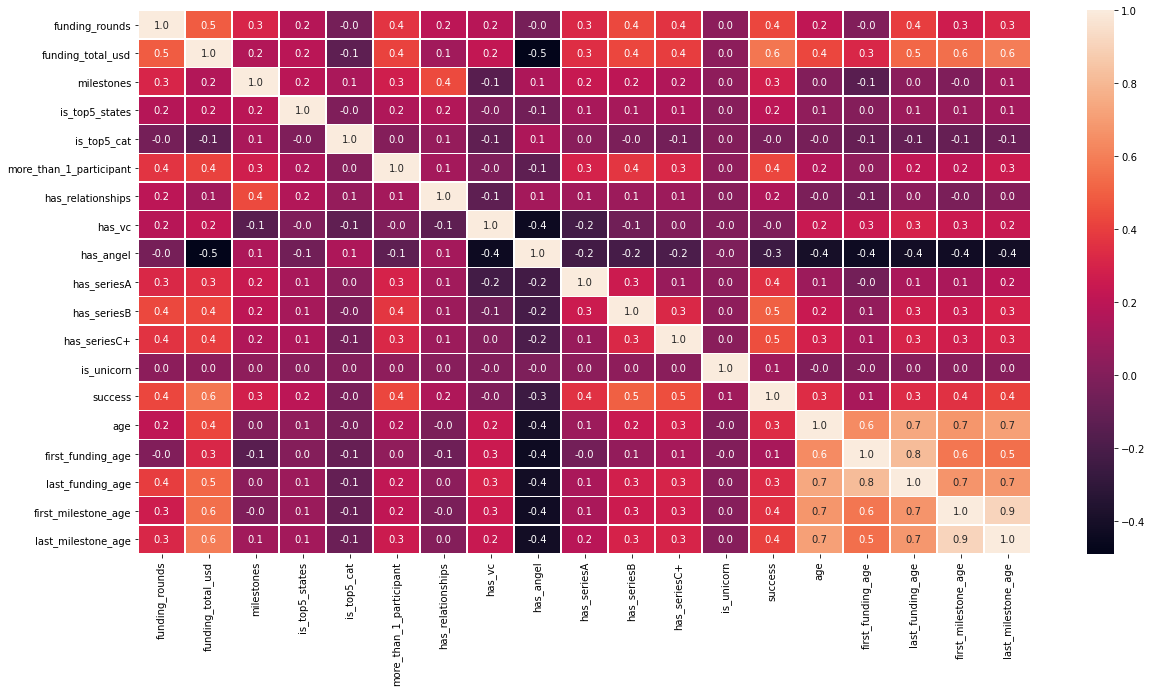

In [26]:
def draw_heatmap(dataset):
    
    f, ax = plt.subplots(figsize = (20, 10))
    
    corrMatt = dataset.corr(method='spearman')
    
    sns.heatmap(corrMatt, annot = True, linewidth = 0.5, fmt = '.1f', ax = ax)
    plt.show()

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numerical_df_1=df_final.select_dtypes(numerics)

draw_heatmap(df_final)

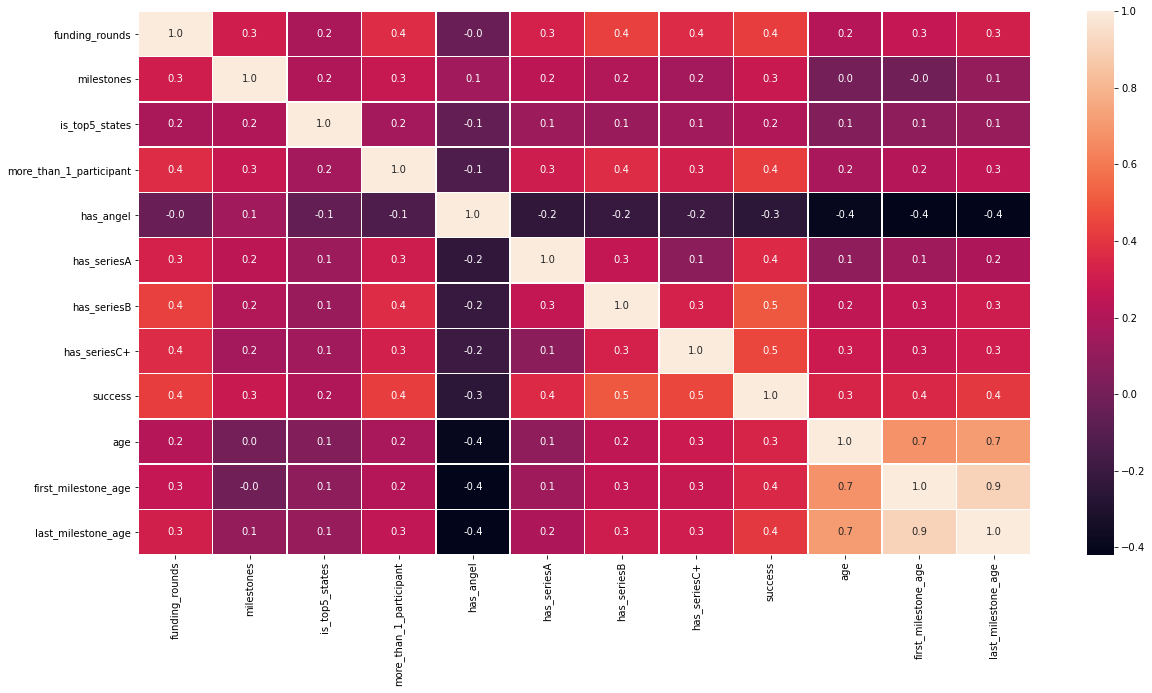

In [27]:
# Criando a matriz de correlação
corr_matrix = numerical_df_1.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.loc["success"]
upper=upper.fillna(0)
upper=upper.to_dict()

# Encontrando variáveis com correlação menor que 0.2 e dropando
to_drop = [key for key in upper if upper[key] < 0.2]

knn_test = df_final.drop(to_drop, axis=1, inplace=True)

numerical_df_4=df_final.select_dtypes(numerics)
draw_heatmap(numerical_df_4)

In [28]:
#dropando colunas desnecessárias
df_final = df_final.drop(['name'], axis=1)

df_final = df_final.drop(['object_id'], axis=1)

**4. Modelagem**

In [30]:
y = df_final["success"].astype(int)
X = df_final.loc[:, df_final.columns != 'success']


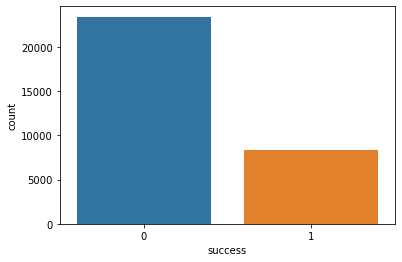

In [31]:
ax = sns.countplot(x=y, data=df_final)


Tratando dados desbalanceados

In [32]:
'''
nr = NearMiss()

Smote gerou resultados melhores'''

'from imblearn.under_sampling import NearMiss\n\nnr = NearMiss()\n\nSmote gerou resultados melhores'

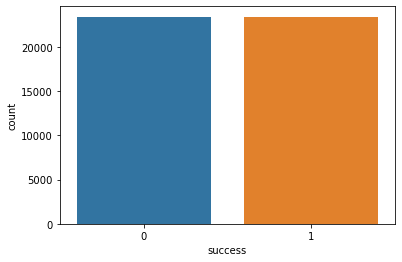

In [35]:
smt = SMOTE()

X, y = smt.fit_resample(X, y)

ax = sns.countplot(x=y)

Definindo os datasets de treino e teste

In [36]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

display("Train: " + str(len(y_train.values)), "Test: " + str(len(y_test.values)))

'Train: 37420'

'Test: 9356'

## Modelos

### Decision Tree

In [47]:
start = time.time()

clf = DecisionTreeClassifier(max_depth=10, random_state = 42)
clf.fit(X_train, y_train)

test_pred_decision_tree = clf.predict(X_test)

print(time.time() - start)

0.12216901779174805


In [48]:
#plot the tree

feature_names = X.columns
labels = str(y)

plt.figure(figsize=(200, 100))

#create the tree plot
a = tree.plot_tree(clf,
                   #use the feature names stored
                   feature_names = feature_names,
                   #use the class names stored
                   class_names = labels,
                   rounded = True,
                   filled = True,
                   fontsize=14)

#show the plot
plt.show()

In [55]:
print('\nconfusion matrix') # generate the confusion matrix
print(confusion_matrix(y_test, test_pred_decision_tree))

roc_auc_score(y_test, test_pred_decision_tree)
print('\nROC Score:',roc_auc_score(y_test, test_pred_decision_tree))

print("Train Accuracy:",clf.score(X_train, y_train))
print("Test Accuracy:",clf.score(X_test, y_test))

print('\nClassification report - test')
print(metrics.classification_report(y_test,
                                    test_pred_decision_tree))

print('\nClassification report - train')
print(metrics.classification_report(y_train,
                                    clf.predict(X_train)))



confusion matrix
[[4359  294]
 [ 630 4073]]

ROC Score: 0.9014289546996149
Train Accuracy: 0.9175841795831107
Test Accuracy: 0.9012398460880718

classification report
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      4653
           1       0.93      0.87      0.90      4703

    accuracy                           0.90      9356
   macro avg       0.90      0.90      0.90      9356
weighted avg       0.90      0.90      0.90      9356

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     18735
           1       0.94      0.89      0.92     18685

    accuracy                           0.92     37420
   macro avg       0.92      0.92      0.92     37420
weighted avg       0.92      0.92      0.92     37420



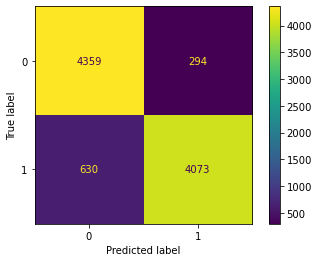

In [51]:
#get the confusion matrix
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

In [56]:
#feature importance
importance = pd.DataFrame({'feature': X_train.columns, 
'importance' : np.round(clf.feature_importances_, 10)})
importance.sort_values('importance', ascending=False, inplace = True)
print(importance)

                    feature  importance
3   more_than_1_participant    0.490984
5               has_seriesA    0.150687
6               has_seriesB    0.141772
7              has_seriesC+    0.088068
10       last_milestone_age    0.024059
0            funding_rounds    0.018986
8                       age    0.018506
2            is_top5_states    0.018503
9       first_milestone_age    0.017787
1                milestones    0.016841
4                 has_angel    0.013809


### Random Forest

In [89]:
start = time.time()

# Create a random forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
rf_clf.fit(X_train, y_train)

# performing predictions on the test dataset
y_pred = rf_clf.predict(X_test)

print(time.time() - start)

3.3280601501464844


In [90]:
print('\nconfusion matrix') # generate the confusion matrix
print(confusion_matrix(y_test, y_pred))

print('\nROC Score:',roc_auc_score(y_test, y_pred))

print("Train Accuracy:",rf_clf.score(X_train, y_train))
print("Test Accuracy:",rf_clf.score(X_test, y_test))

print('\nClassification report - test')
print(metrics.classification_report(y_test,
                                    y_pred))

print('\nClassification report - train')
print(metrics.classification_report(y_train,
                                    rf_clf.predict(X_train)))



confusion matrix
[[4301  352]
 [ 512 4191]]

ROC Score: 0.9077416004773372
Train Accuracy: 0.9979155531801176
Test Accuracy: 0.9076528430953399

Classification report - test
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      4653
           1       0.92      0.89      0.91      4703

    accuracy                           0.91      9356
   macro avg       0.91      0.91      0.91      9356
weighted avg       0.91      0.91      0.91      9356


Classification report - train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18735
           1       1.00      1.00      1.00     18685

    accuracy                           1.00     37420
   macro avg       1.00      1.00      1.00     37420
weighted avg       1.00      1.00      1.00     37420



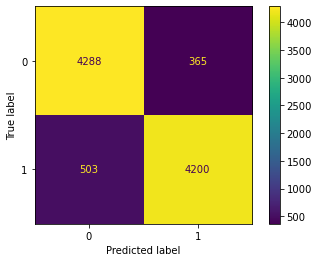

In [65]:
plot_confusion_matrix(rf_clf, X_test, y_test)  
plt.show()

### Gradient Boost

In [66]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 1.5, 2]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, max_features=2, 
                                        max_depth=2, random_state=42)
    gb_clf.fit(X_train, y_train)
    
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.887
Accuracy score (validation): 0.888
Learning rate:  0.075
Accuracy score (training): 0.891
Accuracy score (validation): 0.892
Learning rate:  0.1
Accuracy score (training): 0.895
Accuracy score (validation): 0.896
Learning rate:  0.25
Accuracy score (training): 0.906
Accuracy score (validation): 0.904
Learning rate:  0.5
Accuracy score (training): 0.910
Accuracy score (validation): 0.906
Learning rate:  0.75
Accuracy score (training): 0.913
Accuracy score (validation): 0.908
Learning rate:  1
Accuracy score (training): 0.910
Accuracy score (validation): 0.905
Learning rate:  1.5
Accuracy score (training): 0.790
Accuracy score (validation): 0.786
Learning rate:  2
Accuracy score (training): 0.681
Accuracy score (validation): 0.681


In [87]:
start = time.time()

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

gb_clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.75, max_features=2, max_depth=2, 
                                     random_state=42)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

print(time.time() - start)

1.1551408767700195


In [71]:
print('\nconfusion matrix') # generate the confusion matrix
print(confusion_matrix(y_test, predictions))

print('\nROC Score:',roc_auc_score(y_test, predictions))

print("Train Accuracy:",gb_clf2.score(X_train, y_train))
print("Test Accuracy:",gb_clf2.score(X_test, y_test))

print('\nClassification report - test')
print(metrics.classification_report(y_test,
                                    predictions))

print('\nClassification report - train')
print(metrics.classification_report(y_train,
                                    gb_clf2.predict(X_train)))



confusion matrix
[[4373  280]
 [ 581 4122]]

ROC Score: 0.908142801241819
Train Accuracy: 0.9130678781400321
Test Accuracy: 0.9079734929457033

Classification report - test
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4653
           1       0.94      0.88      0.91      4703

    accuracy                           0.91      9356
   macro avg       0.91      0.91      0.91      9356
weighted avg       0.91      0.91      0.91      9356


Classification report - train
              precision    recall  f1-score   support

           0       0.89      0.94      0.92     18735
           1       0.94      0.88      0.91     18685

    accuracy                           0.91     37420
   macro avg       0.91      0.91      0.91     37420
weighted avg       0.91      0.91      0.91     37420



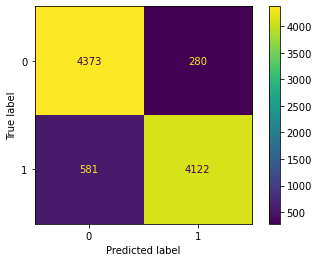

In [70]:
plot_confusion_matrix(gb_clf2, X_test, y_test)  
plt.show()

### SVM

In [74]:
start = time.time()

svm_clf = svm.SVC(kernel='linear')

# Train classifier
svm_clf.fit(X_train, y_train)

# Make predictions on unseen test data
svm_clf_predictions = svm_clf.predict(X_test)

print(time.time() - start)


30.824538946151733


In [76]:
print('\nconfusion matrix') # generate the confusion matrix
print(confusion_matrix(y_test, svm_clf_predictions))

print('\nROC Score:',roc_auc_score(y_test, svm_clf_predictions))

print("Train Accuracy:",svm_clf.score(X_train, y_train))
print("Test Accuracy:",svm_clf.score(X_test, y_test))


print('\nClassification report - test')
print(metrics.classification_report(y_test,
                                    svm_clf_predictions))

print('\nClassification report - train')
print(metrics.classification_report(y_train,
                                    svm_clf.predict(X_train)))



confusion matrix
[[3642 1011]
 [ 644 4059]]

ROC Score: 0.8228934766387094
Train Accuracy: 0.8227151256012827
Test Accuracy: 0.823108165882856

Classification report - test
              precision    recall  f1-score   support

           0       0.85      0.78      0.81      4653
           1       0.80      0.86      0.83      4703

    accuracy                           0.82      9356
   macro avg       0.83      0.82      0.82      9356
weighted avg       0.83      0.82      0.82      9356


Classification report - train
              precision    recall  f1-score   support

           0       0.85      0.78      0.82     18735
           1       0.80      0.86      0.83     18685

    accuracy                           0.82     37420
   macro avg       0.82      0.82      0.82     37420
weighted avg       0.82      0.82      0.82     37420



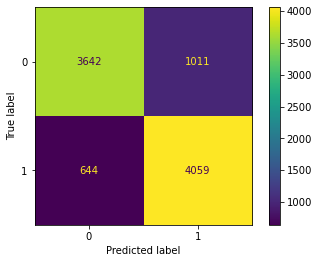

In [77]:
plot_confusion_matrix(svm_clf, X_test, y_test)  
plt.show()

### Naive Bayes

In [81]:
start = time.time()

# define the model
model = GaussianNB()

# fit the model
model.fit(X_train, y_train)

# make a classification prediction
yhat_class = model.predict(X_test)

print(time.time() - start)


0.012651205062866211


In [82]:
print('\nconfusion matrix') # generate the confusion matrix
print(confusion_matrix(y_test, yhat_class))

print('\nROC Score:',roc_auc_score(y_test, yhat_class))

print("Train Accuracy:",model.score(X_train, y_train))
print("Test Accuracy:",model.score(X_test, y_test))


print('\nClassification report - test')
print(metrics.classification_report(y_test,
                                    yhat_class))

print('\nClassification report - train')
print(metrics.classification_report(y_train,
                                    model.predict(X_train)))



confusion matrix
[[4231  422]
 [1217 3486]]

ROC Score: 0.8252674134818171
Train Accuracy: 0.818412613575628
Test Accuracy: 0.8248182984181274

Classification report - test
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      4653
           1       0.89      0.74      0.81      4703

    accuracy                           0.82      9356
   macro avg       0.83      0.83      0.82      9356
weighted avg       0.83      0.82      0.82      9356


Classification report - train
              precision    recall  f1-score   support

           0       0.77      0.90      0.83     18735
           1       0.88      0.73      0.80     18685

    accuracy                           0.82     37420
   macro avg       0.83      0.82      0.82     37420
weighted avg       0.83      0.82      0.82     37420



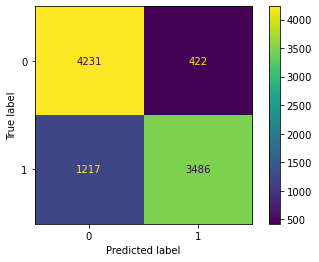

In [83]:
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

### AdaBoostClassifier

In [38]:
start = time.time()

ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train, y_train)
y_predicted = ab.predict(X_test)

print(time.time() - start)

1.0799918174743652


In [62]:
print('\nconfusion matrix') # generate the confusion matrix
print(confusion_matrix(y_test, y_predicted))

roc_auc_score(y_test, y_predicted)
print('\nROC Score:',roc_auc_score(y_test, y_predicted))


print("Train Accuracy:",ab.score(X_train, y_train))
print("Test Accuracy:",ab.score(X_test, y_test))

print('\nClassification report - test')
print(classification_report(y_test, y_predicted))

print('\nClassification report - train')
print(metrics.classification_report(y_train,
                                    ab.predict(X_train)))



confusion matrix
[[4337  316]
 [ 610 4093]]

ROC Score: 0.901191190865957
Train Accuracy: 0.9001336183858899
Test Accuracy: 0.9010260795211629

Classification report - test
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4653
           1       0.93      0.87      0.90      4703

    accuracy                           0.90      9356
   macro avg       0.90      0.90      0.90      9356
weighted avg       0.90      0.90      0.90      9356


Classification report - train
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     18735
           1       0.92      0.87      0.90     18685

    accuracy                           0.90     37420
   macro avg       0.90      0.90      0.90     37420
weighted avg       0.90      0.90      0.90     37420



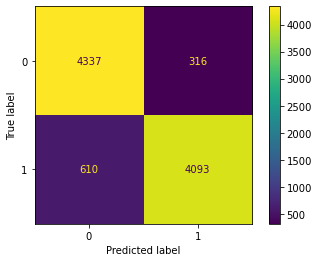

In [45]:
plot_confusion_matrix(ab, X_test, y_test)  
plt.show()

Text(0.5, 1.0, 'feature importance score')

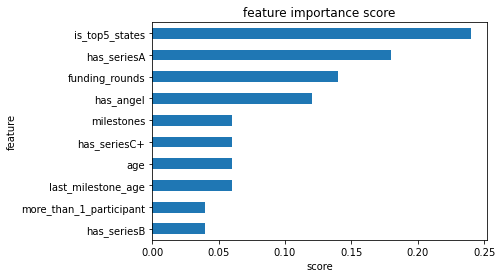

In [46]:
feat_importances = pd.Series(ab.feature_importances_, index=X.columns)
ax = feat_importances.nlargest(10).plot(kind='barh')
ax.invert_yaxis()
plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')